# Практическая работа №5

# Выполнил студент группы ББМО-02-23 Ионов М.С.

## Шаги выполнения

### Шаг 1. Загрузка обученной модели и данных MNIST

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# Загрузка тестовых данных MNIST
(_, _), (test_images, test_labels) = mnist.load_data()

# Нормализация данных
test_images = test_images / 255.0

# Преобразование меток в формат one-hot
test_labels = to_categorical(test_labels, num_classes=10)

# Загрузка обученной модели
model = tf.keras.models.load_model('/content/drive/MyDrive/AZSII/Pract_5/mnist_model.h5')

# Проверка точности модели на обычных данных
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy on clean images: {test_acc}')


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9715 - loss: 0.0998
Test accuracy on clean images: 0.9754999876022339


###Шаг 2: Реализация атаки PGD

In [ ]:
!pip install foolbox


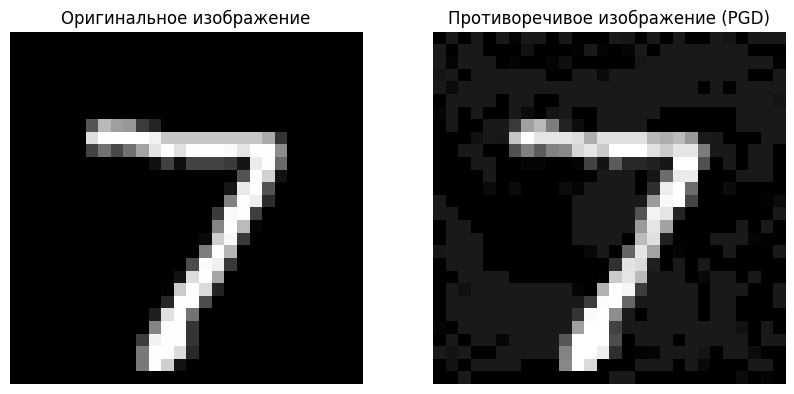

In [ ]:
import torch
import torch.nn as nn
import foolbox as fb
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Инициализация Foolbox модели
fmodel = fb.TensorFlowModel(model, bounds=(0, 1))

# Выбор изображения для атаки (например, первое изображение из тестового набора)
image = tf.convert_to_tensor(test_images[0], dtype=tf.float32)[None, ...]  # Добавляем размерность для батча
label = np.argmax(test_labels[0])  # Получаем индекс класса
label = tf.convert_to_tensor(label, dtype=tf.int64)  # Преобразуем в тензор

# Выполнение атаки
attack = fb.attacks.LinfPGD()
#print(label)
advs, _, success = attack(fmodel, image, label[None], epsilons=0.1)  # Оборачиваем метку в тензор с размерностью (1,)

# Вывод результатов
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Оригинальное изображение")
plt.imshow(image[0].numpy(), cmap="gray")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Противоречивое изображение (PGD)")
plt.imshow(advs[0].numpy(), cmap="gray")
plt.axis('off')

plt.show()

###Шаг 3: Оценка модели на противоречивых примерах

In [ ]:
import time


adversarial_images = []


# Обработка изображений
for i in range(len(test_images)):
    image = tf.convert_to_tensor(test_images[i], dtype=tf.float32)[None, ...]  # Форма (1, height, width, channels)
    label = np.argmax(test_labels[i])  # Получаем индекс класса
    label = tf.convert_to_tensor(label, dtype=tf.int64)
    advs, _, success = attack(fmodel, image, label[None], epsilons=0.1)
    adversarial_images.append(advs)


# Конвертация списка в массив с правильной формой

adversarial_images = tf.concat(adversarial_images, axis=0)  # Объединение по нулевой оси

# Убедитесь, что test_labels имеют соответствующее количество меток
adversarial_loss, adversarial_acc = model.evaluate(adversarial_images, test_labels)
print(f'Accuracy on adversarial examples (PGD): {adversarial_acc}')
print('ББМО-01-23 Курдюков А.А.')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0654 - loss: 7.7959
Accuracy on adversarial examples (PGD): 0.08569999784231186
ББМО-01-23 Курдюков А.А.


#Вывод:
Модель имеет высокую уязвимость к атакам типа PGD (Projected Gradient Descent). Изначальная точность в 97,5% свидетельствует о том, что модель хорошо справляется с тестовыми данными при нормальных условиях. Однако резкое снижение точности до 8,5% после применения атаки PGD показывает, что модель не устойчива к небольшим, но целенаправленным изменениям входных данных, которые могут быть эффективно использованы для введения в заблуждение модели.